In [1]:
# List of questions and to be done items that are not obvious
# how do I learn what flags are?
# offset - maybe only of bad images 

# Explore AuxTel Prompt Processing Subtractions + APDB
Neven Caplar 
Started: 2023-09-12

Goals:

References
1. Track Prompt Processing AuxTel runs here  
    https://confluence.lsstcorp.org/display/DM/Prompt+Processing+with+AuxTel+Imaging+Survey+Data+2023  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import pandas as pd
import astropy.units as u
from astropy.time import Time

# run before notebook: 'source /sdf/group/rubin/sw/loadLSST.bash'
# add also -
# lsst.analysis.ap not yet in lsst distrib, just a dm package
# so github clone from https://github.com/lsst/analysis_ap
# and add to your notebooks/.user_setups
# setup -k -r <PATH_To_Directory>/analysis_ap
#

# AP LSST import
from lsst.analysis.ap import apdb, CutoutPath

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')



In [2]:
# all of the other lsst imports
import lsst.afw.display as afwDisplay
from lsst.analysis.tools.actions.vector import ConvertUnits, FlagSelector, GoodDiaSourceSelector, LoadVector
from lsst.analysis.tools.atools import SkySourceHistPlot, SkySourceSkyPlot, NumDiaSourcesAllMetric, NumDiaSourcesMetric, NumDipolesMetric
import lsst.daf.butler as dafButler
from lsst.daf.butler import DataCoordinate
import lsst.geom as geom

from IPython.display import Image, display
afwDisplay.setDefaultBackend('matplotlib')
%matplotlib inline

## Create lightcurves 

In [14]:
# let us use apdbQuery
help(apdbQuery.load_sources)

Help on method load_sources in module lsst.analysis.ap.apdb:

load_sources(exclude_flagged=False, limit=100000) method of lsst.analysis.ap.apdb.ApdbPostgresQuery instance
    Load diaSources.
    
    Parameters
    ----------
    exclude_flagged : `bool`, optional
        Exclude sources that have selected flags set.
        Use `set_excluded_diaSource_flags` to configure which flags
        are excluded.
    limit : `int`
        Maximum number of rows to return.
    
    Returns
    -------
    data : `pandas.DataFrame`
        All available diaSources.



In [15]:
repo = "/sdf/group/rubin/repo/embargo/"
butler = dafButler.Butler(repo)
schema = 'pp_apdb'
instrument = 'LATISS'
apdbQuery = apdb.ApdbPostgresQuery(schema, url="rubin@usdf-prompt-processing.slac.stanford.edu/lsst-devl",\
                                   butler=butler, instrument=instrument)
sources = apdbQuery.load_sources(exclude_flagged=True)

# this seems to be a bug - you can pass any value even though it should only be bool
sources_67 = apdbQuery.load_sources(exclude_flagged =1000007)
len(sources_67)

sources_cortado = sources[['diaSourceId','diaObjectId','ra','dec','x','y','midpointMjdTai','psfFlux','psfFluxErr','scienceFlux','scienceFluxErr','snr', 'band','flags','visit']]


# replacing visit value with correct values
# see this slack discussion https://lsstc.slack.com/archives/C2B6X08LS/p1694212674366649?thread_ts=1694211760.066429&cid=C2B6X08LS
# Specific Dimension Packer 
from lsst.obs.lsst import RubinDimensionPacker
# The constructor data ID has the dimensions that must not change
packer = RubinDimensionPacker(DataCoordinate.standardize({"instrument": 'LATISS'}, universe=butler.dimensions), config=RubinDimensionPacker.ConfigClass(), is_exposure=False)
packer.pack({"instrument": 'LATISS', "detector": 0, "visit": 2023072000156})
dataId = DataCoordinate.standardize({"instrument": 'LATISS', "detector": 0, "visit": 2023072000156}, universe=butler.dimensions)
packer.pack(dataId)  # Both work
packer.unpack(41506872320)


unpacked_val = list(map(packer.unpack,sources_cortado['visit'].values))
visit_values = np.array([item['visit'] for item in unpacked_val])
sources_cortado = sources_cortado.assign(visit=visit_values)

In [16]:
sources_cortado

,diaSourceId,diaObjectId,ra,dec,x,y,midpointMjdTai,psfFlux,psfFluxErr,scienceFlux,scienceFluxErr,snr,band,flags,visit
0,174092440599265520,174092440599265520,240.088515,-24.098469,3358.256836,110.854713,60146.030187,-119309.325752,23944.414197,-7.708066e+04,33210.161551,5.031761,r,0,2023072000156
1,174092440599265523,174092440599265523,240.091971,-24.096410,3477.986084,186.705460,60146.030187,-129261.900190,23884.525208,-1.350225e+05,33090.438275,5.183794,r,0,2023072000156
2,174092440599265526,174092440599265526,240.085857,-24.094408,3269.029785,264.858948,60146.030187,-113646.521691,23840.146683,-1.228520e+05,32970.035617,5.029581,r,0,2023072000156
3,174092440599265530,174092440599265530,240.089785,-24.093083,3404.597412,312.855194,60146.030187,-144437.904842,23768.893188,-1.570438e+05,32981.004732,6.249032,r,0,2023072000156
4,174092440599265536,174092440599265536,240.097468,-24.082916,3673.623047,691.734070,60146.030187,125107.850921,21392.127181,1.327670e+05,29250.303565,5.315273,r,0,2023072000156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67948,175500191292457741,175500082844533363,270.157865,-24.991700,1898.108486,3862.541610,60186.208579,-164.329959,11735.130724,1.411840e+06,10430.920271,5.456339,r,0,2023082900506
67949,175500191292457743,175500191292457743,270.181817,-24.991705,2714.373779,3852.540771,60186.208579,23486.094267,8917.360051,1.388023e+04,7961.952471,6.036020,r,0,2023082900506
67950,175500191292457747,175500030231184021,270.185047,-24.992866,2823.870117,3807.539307,60186.208579,62209.503212,9048.465189,7.293840e+04,8063.196389,6.830311,r,0,2023082900506
67951,175500191292457750,174092479253972518,270.215273,-24.988667,3856.057818,3952.851170,60186.208579,-887488.147292,28058.154277,1.828086e+07,27275.602000,32.012589,r,8388608,2023082900506


In [18]:
# add brightness derived from science images
"""
Schema says: 
https://github.com/lsst/sdm_schemas/blob/0d3fc262d112470a76879c0bc2f2b8d1b6adabd3/yml/apdb.yaml#L2145

- name: scienceFlux
"@id": "#DiaSource.scienceFlux"
datatype: float
description: Forced photometry flux for a point source model measured on the visit image
  centered at DiaSource position.
mysql:datatype: FLOAT
fits:tunit: nJy
ivoa:ucd: phot.count
"""
# add a column with brightness
# sources_cortado['mag'] = (sources_cortado['scienceFlux']).values*u.nJy.to(u.ABmag) / this seems to be wrong
sources_cortado['mag'] = u.nJy.to(u.ABmag, sources_cortado['scienceFlux'])

# add a column with error estimate for brightness 
upper_mag = u.nJy.to(u.ABmag, sources_cortado['scienceFlux']+sources_cortado['scienceFluxErr'])
lower_mag = u.nJy.to(u.ABmag, sources_cortado['scienceFlux']-sources_cortado['scienceFluxErr'])
magErr = -(upper_mag-lower_mag)/2
sources_cortado['magErr'] = magErr

### Investigating the difference between the query with exclude_flagged and without exclude_flagged - DEPRECATED

In [21]:
"""
plt.figure(figsize=(20,4))
plt.subplot(131)
plt.scatter(sources['ra'],sources['dec'])
plt.xlim(237,273)
plt.ylim(-25.6,-23.8)
plt.xlabel('ra')
plt.ylabel('dec')

plt.subplot(132)
plt.scatter(sources_67['ra'],sources_67['dec'])
plt.xlim(237,273)
plt.ylim(-25.6,-23.8)
plt.xlabel('ra')
plt.ylabel('dec')
"""

"\nplt.figure(figsize=(20,4))\nplt.subplot(131)\nplt.scatter(sources['ra'],sources['dec'])\nplt.xlim(237,273)\nplt.ylim(-25.6,-23.8)\nplt.xlabel('ra')\nplt.ylabel('dec')\n\nplt.subplot(132)\nplt.scatter(sources_67['ra'],sources_67['dec'])\nplt.xlim(237,273)\nplt.ylim(-25.6,-23.8)\nplt.xlabel('ra')\nplt.ylabel('dec')\n"

In [20]:
"""
# why is there a difference
# there is a difference in a number of unique sources
print(len(np.unique(sources['diaObjectId'])))
print(len(np.unique(sources_67['diaObjectId'])))

# Question -> unsolved at this point
"""

"\n# why is there a difference\n# there is a difference in a number of unique sources\nprint(len(np.unique(sources['diaObjectId'])))\nprint(len(np.unique(sources_67['diaObjectId'])))\n\n# Question -> unsolved at this point\n"

## Looking at lightcurves

In [22]:
# what are the flags that are present in the data
# how do I learn what these flags are?
np.unique(sources['flags'], return_counts=True)

(array([       0,  8388608, 41943040, 47939584]),
 array([49135, 17973,   842,     3]))

In [10]:
# select only the one where the flag is 0
# that is too conservative; we already did exclude_flagged
# sources_cortado = sources_cortado[sources_cortado['flags']==0]

In [23]:
# number of observations for each object
# there must be a better way
uniq_obj = np.unique(sources_cortado['diaObjectId'])

list_of_len_sources = []
for diaObjectId in uniq_obj:
    try:
        sources_select = sources_cortado[sources_cortado['diaObjectId'] ==  diaObjectId]
        list_of_len_sources.append([sources_select['diaObjectId'].iloc[0],len(sources_select)])
    except:
        pass
    
array_of_len_sources = np.array(list_of_len_sources)

# Select the lightcurve with more than 20 observations
array_of_len_sources_20 = array_of_len_sources[array_of_len_sources[:,1]>20]

In [24]:
sources_cortado_select = sources_cortado[sources_cortado['diaObjectId'] ==  array_of_len_sources_20[10][0]]
sources_cortado_select

,diaSourceId,diaObjectId,ra,dec,x,y,midpointMjdTai,psfFlux,psfFluxErr,scienceFlux,scienceFluxErr,snr,band,flags,visit,mag,magErr
3989,174092495360099424,174092443820491173,270.245991,-24.987184,459.764619,2142.767106,60146.069105,1.647858e+06,28211.541464,5.790045e+06,31804.751168,84.866180,r,8388608,2023072000207,14.493295,0.005964
5382,174092514687451733,174092443820491173,270.246008,-24.987263,1905.904044,3207.738280,60146.080359,5.099151e+05,32091.602957,5.429396e+06,39750.601944,45.017742,r,8388608,2023072000225,14.563121,0.007949
9197,174092709034721669,174092443820491173,270.246098,-24.987240,1568.086390,3276.538530,60146.236193,-3.448189e+05,298354.302230,4.030867e+06,380910.996897,5.479129,r,0,2023072000406,14.886504,0.102908
16102,175077939098944683,174092443820491173,270.246010,-24.987299,2027.776409,3715.242367,60174.164930,-1.524119e+05,26479.143970,2.408639e+07,34362.819592,49.374363,i,8388608,2023081700469,12.945571,0.001549
16598,175077941246427945,174092443820491173,270.246049,-24.987343,2032.646566,3712.255685,60174.165956,-2.603611e+05,12704.198166,4.824097e+06,16400.251580,16.119137,r,8388608,2023081700471,14.691460,0.003691
22954,175077965942489795,174092443820491173,270.246076,-24.987301,2582.008145,2588.934437,60174.178620,-6.501854e+04,6614.075427,6.365352e+05,9474.847905,5.126226,g,8388608,2023081700494,16.890444,0.016162
23401,175077968089973505,174092443820491173,270.246016,-24.987365,2017.134501,2593.451468,60174.179768,-1.566813e+05,13324.354893,5.416294e+06,17940.556314,14.338446,r,8388608,2023081700496,14.565744,0.003596
23960,175077970237457335,174092443820491173,270.245979,-24.987100,2015.110068,2601.249135,60174.180795,-5.922476e+04,25006.555305,2.313070e+07,33236.580544,38.464554,i,8388608,2023081700498,12.989528,0.001560
25874,175077977753649857,174092443820491173,270.245836,-24.987436,3663.929284,1456.352926,60174.184723,-6.529928e+05,25267.330836,2.111172e+07,38666.628559,9.058201,i,8388608,2023081700505,13.088691,0.001989
26312,175077979901133449,174092443820491173,270.246082,-24.987185,3676.580298,1466.969120,60174.185748,-2.056580e+05,14225.160278,5.634481e+06,19971.936875,9.514829,r,0,2023081700507,14.522865,0.003849


Text(0, 0.5, 'science flux [nJy]')

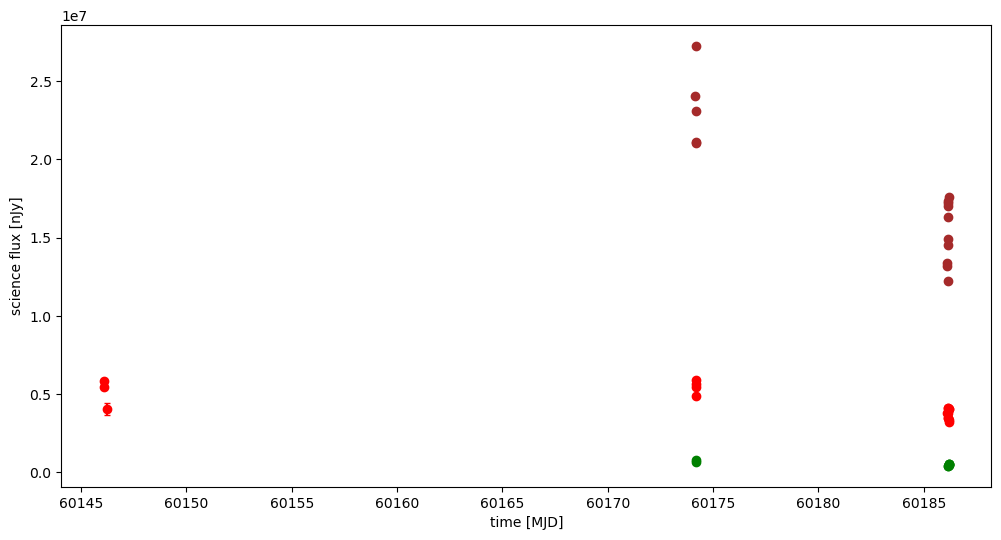

In [28]:
plt.figure(figsize=(12,6))
plt_color_band = ['green', 'red', 'brown']
for i,band in enumerate(['g', 'r', 'i']):
    sources_cortado_select_sband = sources_cortado_select[sources_cortado_select['band'] == band]

    plt.errorbar(sources_cortado_select_sband['midpointMjdTai'],sources_cortado_select_sband['scienceFlux'],yerr=sources_cortado_select_sband['scienceFluxErr'],
                 marker='o', capsize=2, ls='', color = plt_color_band[i])

    
plt.xlabel('time [MJD]')
plt.ylabel('science flux [nJy]')

Text(0, 0.5, 'science flux [nJy]')

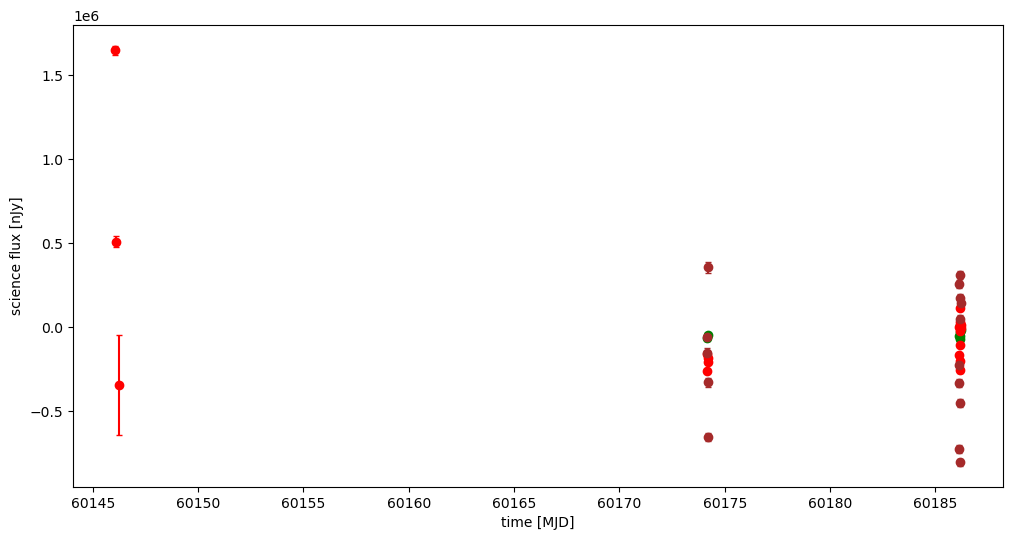

In [29]:
plt.figure(figsize=(12,6))
plt_color_band = ['green', 'red', 'brown']
for i,band in enumerate(['g', 'r', 'i']):
    sources_cortado_select_sband = sources_cortado_select[sources_cortado_select['band'] == band]

    plt.errorbar(sources_cortado_select_sband['midpointMjdTai'],sources_cortado_select_sband['psfFlux'],yerr=sources_cortado_select_sband['psfFluxErr'],
                 marker='o', capsize=2, ls='', color = plt_color_band[i])

plt.xlabel('time [MJD]')
plt.ylabel('science flux [nJy]')



Text(0, 0.5, 'science brightness [mag]')

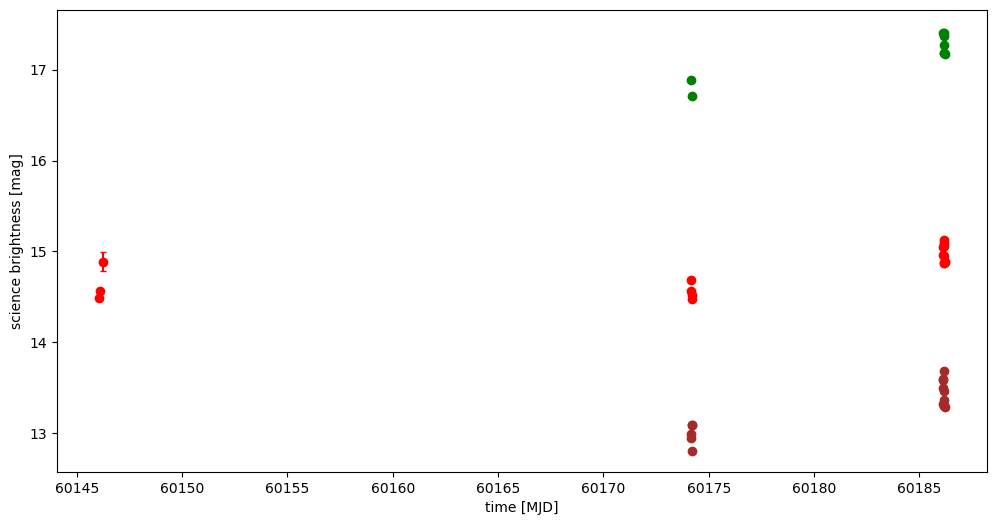

In [30]:
plt.figure(figsize=(12,6))
plt_color_band = ['green', 'red', 'brown']
for i,band in enumerate(['g', 'r', 'i']):
    sources_cortado_select_sband = sources_cortado_select[sources_cortado_select['band'] == band]

    plt.errorbar(sources_cortado_select_sband['midpointMjdTai'],sources_cortado_select_sband['mag'],yerr=sources_cortado_select_sband['magErr'],
                 marker='o', capsize=2, ls='', color = plt_color_band[i])
    
plt.xlabel('time [MJD]')
plt.ylabel('science brightness [mag]')

In [ ]:
plt_color_band = ['green', 'red', 'brown']
for i,band in enumerate(['g', 'r', 'i']):
    sources_cortado_select_sband = sources_cortado_select[sources_cortado_select['band'] == band]

    plt.errorbar(sources_cortado_select_sband['midpointMjdTai'],sources_cortado_select_sband['mag'],yerr=sources_cortado_select_sband['magErr'],
                 marker='o', capsize=2, ls='', color = plt_color_band[i])

sources_cortado_select = sources_cortado[sources_cortado['diaObjectId'] ==  array_of_len_sources_20[10][0]]
sources_cortado_select

In [48]:
sources_cortado_select[diaSourceId]
sources_cortado_select_sband.iloc[4]

diaSourceId       175077989564809969
diaObjectId       174092443820491173
ra                        270.245983
dec                       -24.987226
x                         1997.93201
y                        1482.624891
midpointMjdTai          60174.190808
psfFlux                356695.283797
psfFluxErr              30535.125954
scienceFlux          27240764.496468
scienceFluxErr          41427.290343
snr                        35.823074
band                               i
flags                        8388608
visit                  2023081700516
mag                        12.811952
magErr                      0.001651
Name: 28543, dtype: object

## look at the single visit, single cutout

In [15]:
# let us try to get image from visit from 2023081700470

In [16]:
# This information can be also found here: https://confluence.lsstcorp.org/display/DM/Prompt+Processing+with+AuxTel+Imaging+Survey+Data+2023
! butler query-collections /sdf/group/rubin/repo/embargo "LATISS/prompt/*-2023-0*/ApPipe/*"


                               Name                               Type
----------------------------------------------------------------- ----
LATISS/prompt/output-2023-05-24/ApPipe/prompt-proto-service-00026 RUN 
LATISS/prompt/output-2023-05-25/ApPipe/prompt-proto-service-00027 RUN 
LATISS/prompt/output-2023-07-20/ApPipe/prompt-proto-service-00007 RUN 
LATISS/prompt/output-2023-08-15/ApPipe/prompt-proto-service-00010 RUN 
LATISS/prompt/output-2023-08-16/ApPipe/prompt-proto-service-00011 RUN 
LATISS/prompt/output-2023-08-17/ApPipe/prompt-proto-service-00011 RUN 
LATISS/prompt/output-2023-08-29/ApPipe/prompt-proto-service-00013 RUN 


In [49]:
# Start with some time in modified julian date (MJD)
mjd = 60174.165443

# Convert to Julian Date
jd = mjd + 2400000.5

# Convert to astropy Time object
t = Time(jd, format='jd')

# Convert to datetime
utc = t.to_datetime()
utc

datetime.datetime(2023, 8, 18, 3, 58, 14, 275193)

In [50]:
! butler query-datasets /sdf/group/rubin/repo/embargo \
    --collections "LATISS/prompt/output-2023-08-17/ApPipe/prompt-proto-service-00011" \
    --where "instrument='LATISS' and detector=0 and band='g' and visit >= 2023081700470 and visit <= 2023081700470" \
    deepDiff_differenceExp


         type                                         run                                                 id                  band instrument detector physical_filter      visit    
---------------------- ----------------------------------------------------------------- ------------------------------------ ---- ---------- -------- ---------------- -------------
deepDiff_differenceExp LATISS/prompt/output-2023-08-17/ApPipe/prompt-proto-service-00011 c8def79d-ab38-47c4-a5d7-dd65cfc0a797    g     LATISS        0 SDSSg_65mm~empty 2023081700470



In [51]:
ap_collection = "LATISS/prompt/output-2023-08-17/ApPipe/prompt-proto-service-00011"
data_id = {"instrument": "LATISS", "detector": 0, "band": "i", "visit": 2023081700516}

calexp = butler.get("calexp", dataId=data_id, collections=ap_collection)
diff = butler.get("deepDiff_differenceExp", dataId=data_id, collections=ap_collection)
template = butler.get("deepDiff_templateExp", dataId=data_id, collections=ap_collection)
matched_template = butler.get("deepDiff_matchedExp", dataId=data_id, collections=ap_collection)

# Includes detections and sky sources. Direct output from detect+measure after image subtraction.
diaSrc = butler.get("deepDiff_diaSrc", dataId=data_id, collections=ap_collection)
# The SDM/DPDD (Science Data Model/Data Products Definition Document) version of the diaSrc Table. No sky sources.  Flags are packed into uint64.
diaSrcTable = butler.get("deepDiff_diaSrcTable", dataId=data_id, collections=ap_collection)

calexp

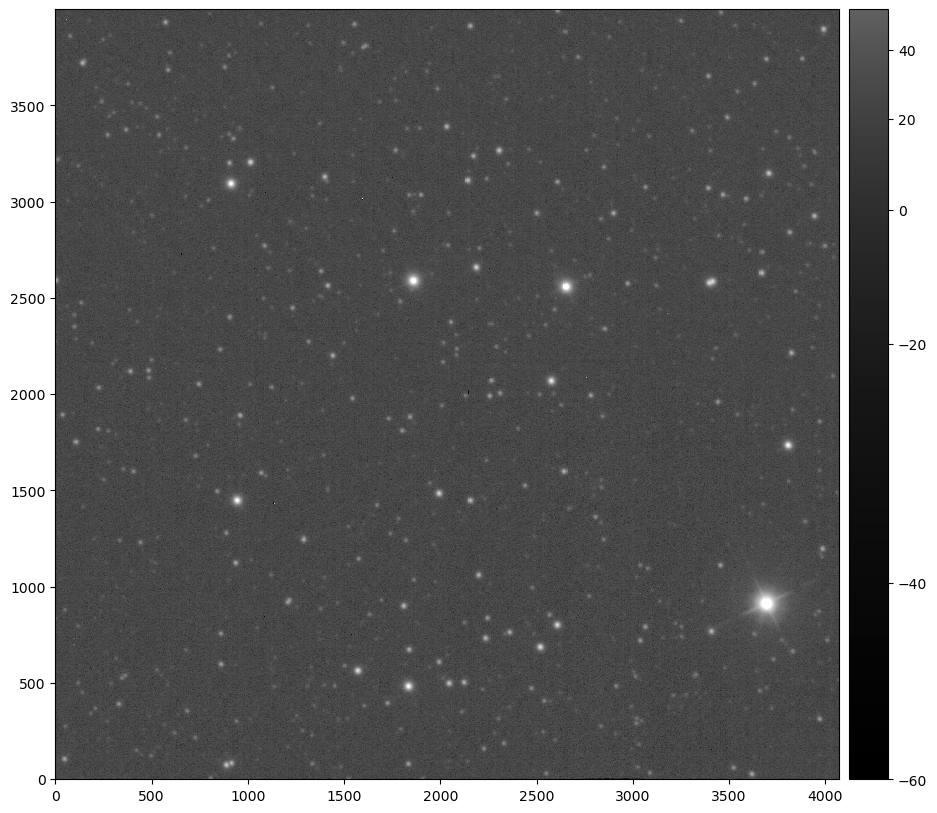

In [52]:
fig = plt.figure(figsize=(12, 10))
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(calexp.image)
plt.show()

In [56]:
def show_cutout_triplet(template, science, diff, x, y, size=30, figsize=(16, 8)):
    """
    Create and show a cutout of an template, science and difference image
    given a position
    """
    xy = geom.PointI(x, y)
    cutoutSize = geom.ExtentI(size, size)
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    
    assert template.getDimensions() == science.getDimensions() == diff.getDimensions()
    
    # clipping to the dimension of the image; prevents clipping outside of the image 
    bbox = bbox.clippedTo(template.getBBox())
    print(x, y, bbox)
    template_cutout = template.getCutout(bbox)
    science_cutout = science.getCutout(bbox)
    diff_cutout = diff.getCutout(bbox)

    # Use diff sigma for calexp, diff ranges.
    sigma = np.sqrt(np.median(diff.variance.array))

    fit, axes = plt.subplots(1, 3, figsize=figsize)
    plt.sca(axes[0])
    plt.imshow(template_cutout.image.array, cmap="gray", origin='lower')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title("Template")
    plt.sca(axes[1])
    plt.imshow(science_cutout.image.array, cmap="gray", vmin=-5*sigma, vmax=+5*sigma, origin='lower')
    plt.title("Science")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.sca(axes[2])
    plt.imshow(diff_cutout.image.array, cmap="gray", vmin=-5*sigma, vmax=+5*sigma, origin='lower')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title("Diff")

In [ ]:
template.getDimensions()

In [ ]:
sources_cortado_select.loc[28543]

1997.932009591044 1482.6248910656154
1997.932009591044 1482.6248910656154 (minimum=(1932, 1417), maximum=(2061, 1546))


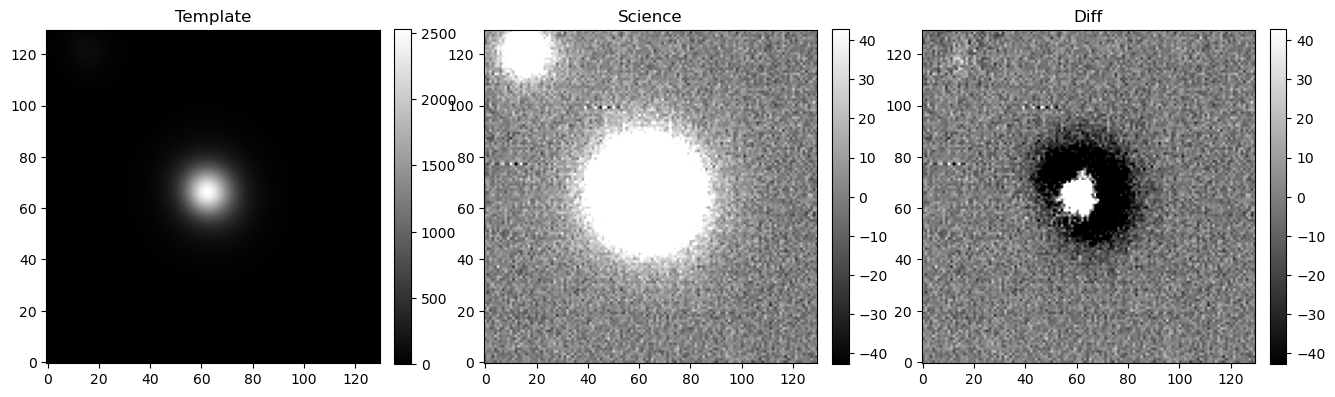

In [57]:
stamp_size = 30 # pixels.  Size of baseline alert stamp
stamp_size = 130 # pixels.  Size of baseline alert stamp
x = sources_cortado_select.loc[28543]['x']
y = sources_cortado_select.loc[28543]['y']

print(x, y)
show_cutout_triplet(matched_template, calexp, diff, x, y, size=stamp_size)

In [ ]:
# why only one/few sources when more obvious present

In [58]:
sources_cortado_select.loc[28543]

diaSourceId       175077989564809969
diaObjectId       174092443820491173
ra                        270.245983
dec                       -24.987226
x                         1997.93201
y                        1482.624891
midpointMjdTai          60174.190808
psfFlux                356695.283797
psfFluxErr              30535.125954
scienceFlux          27240764.496468
scienceFluxErr          41427.290343
snr                        35.823074
band                               i
flags                        8388608
visit                  2023081700516
mag                        12.811952
magErr                      0.001651
Name: 28543, dtype: object